In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn kagglehub

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import kagglehub


In [ ]:
import kagglehub

# Download the UNSW-NB15 dataset
path = kagglehub.dataset_download("mrwellsdavid/unsw-nb15")

print("✅ Dataset downloaded to:", path)


Using Colab cache for faster access to the 'unsw-nb15' dataset.
✅ Dataset downloaded to: /kaggle/input/unsw-nb15


In [ ]:
import os
os.listdir(path)

['UNSW_NB15_testing-set.csv',
 'UNSW-NB15_1.csv',
 'UNSW_NB15_training-set.csv',
 'UNSW-NB15_LIST_EVENTS.csv',
 'UNSW-NB15_4.csv',
 'UNSW-NB15_3.csv',
 'UNSW-NB15_2.csv',
 'NUSW-NB15_features.csv']

In [ ]:
train_file = '/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv'
test_file =  '/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv'


In [ ]:
import pandas as pd

# Load training and testing data
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

print("✅ Training data shape:", train_df.shape)
print("✅ Testing data shape:", test_df.shape)


✅ Training data shape: (82332, 45)
✅ Testing data shape: (82332, 45)


In [ ]:
# Quick overview
print("Training shape:", train_df.shape)
print("Testing shape:", test_df.shape)

# Check structure
train_df.info()
print("\nLabel distribution (training):\n", train_df['label'].value_counts())


Training shape: (82332, 45)
Testing shape: (82332, 45)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss          

In [ ]:
import numpy as np

# Replace inf / -inf with NaN
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN with 0 (safe for numeric features)
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [ ]:
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']

X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

print("✅ Features and labels separated")

✅ Features and labels separated


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Find categorical (object/string) columns
cat_cols = X_train.select_dtypes(include=['object']).columns
print("Categorical columns:", list(cat_cols))

# Apply the same encoder to both sets
le = LabelEncoder()
for col in cat_cols:
    # Fit on training, transform both to avoid unseen values
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))


Categorical columns: ['proto', 'service', 'state', 'attack_cat']


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("✅ Scaling complete")


✅ Scaling complete


In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("✅ After SMOTE:")
print("Original training set size:", len(y_train))
print("Balanced training set size:", len(y_train_res))
print("Class distribution:\n", y_train_res.value_counts())


✅ After SMOTE:
Original training set size: 82332
Balanced training set size: 90664
Class distribution:
 label
0    45332
1    45332
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,      # number of trees
    max_depth=None,        # let trees grow until pure
    random_state=42,
    n_jobs=-1              # use all CPU cores
)

# Train on the resampled (balanced) training set
rf_model.fit(X_train_res, y_train_res)

print("✅ Random Forest training complete")


✅ Random Forest training complete


In [ ]:
# Predict on the test set (do NOT apply SMOTE to test)
y_pred = rf_model.predict(X_test_scaled)

# Optional: predict probabilities for ROC/PR curve later
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37000
           1       1.00      1.00      1.00     45332

    accuracy                           1.00     82332
   macro avg       1.00      1.00      1.00     82332
weighted avg       1.00      1.00      1.00     82332



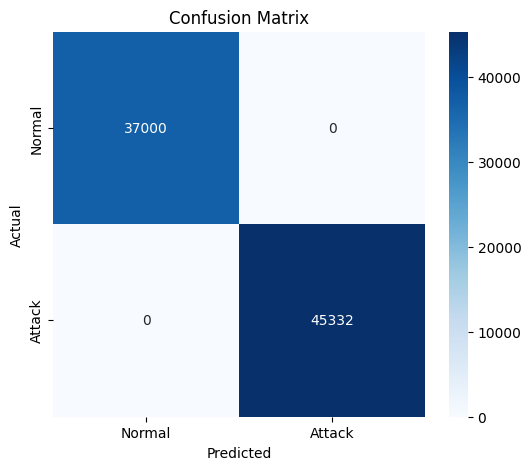

In [ ]:
# Accuracy, precision, recall, F1
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal','Attack'], yticklabels=['Normal','Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


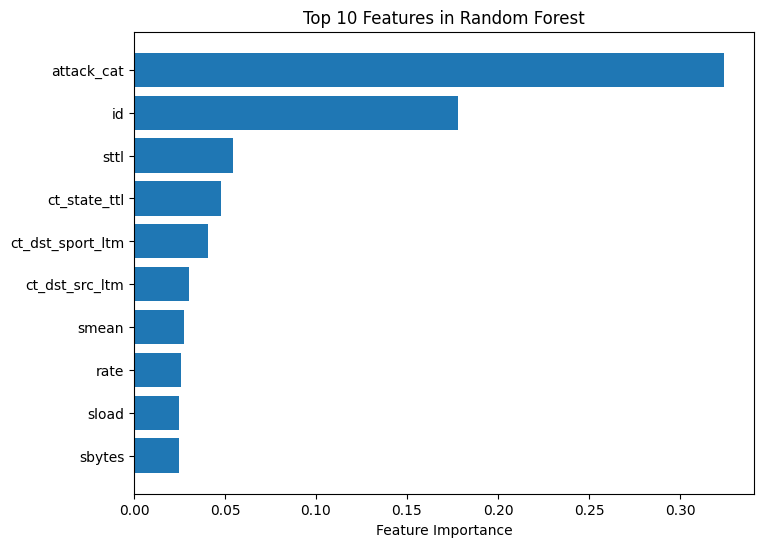

In [ ]:
# Get feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features

# Plot
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), np.array(X_train.columns)[indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Features in Random Forest")
plt.show()


In [ ]:
import joblib

# Save trained model for future use or deployment
joblib.dump(rf_model, "rf_ids_model.pkl")
print("✅ Model saved as rf_ids_model.pkl")

✅ Model saved as rf_ids_model.pkl


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to handle class imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("✅ After SMOTE:")
print("Original training shape:", X_train.shape, y_train.shape)
print("Resampled training shape:", X_train_res.shape, y_train_res.shape)


✅ After SMOTE:
Original training shape: (82332, 44) (82332,)
Resampled training shape: (90664, 44) (90664,)


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring='f1',  # F1 is ideal for imbalanced IDS tasks
    verbose=2,
    n_jobs=-1
)

# Fit to resampled data
grid_search.fit(X_train_res, y_train_res)

print("✅ Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on test data
y_pred = best_model.predict(X_test)

# Show results
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


✅ Accuracy: 0.9999878540543167

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     37000
           1       1.00      1.00      1.00     45332

    accuracy                           1.00     82332
   macro avg       1.00      1.00      1.00     82332
weighted avg       1.00      1.00      1.00     82332


Confusion Matrix:
 [[36999     1]
 [    0 45332]]


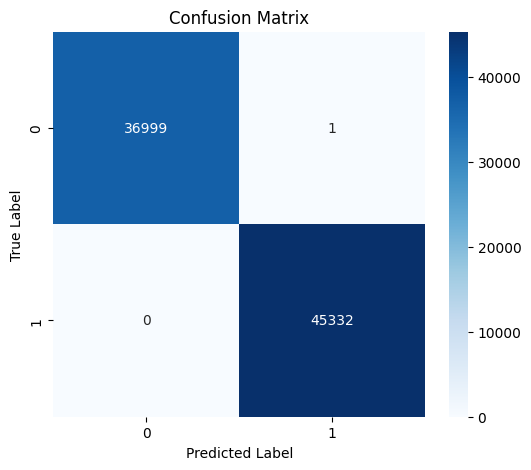

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


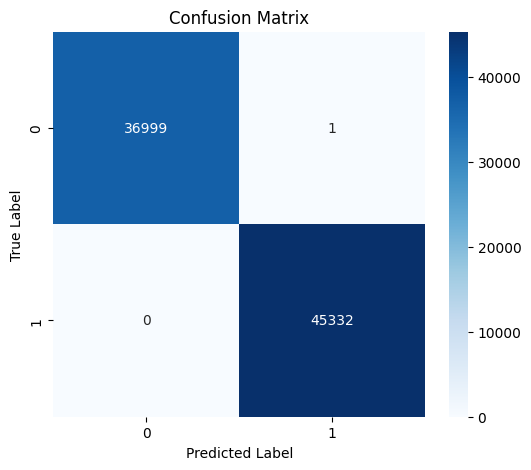

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


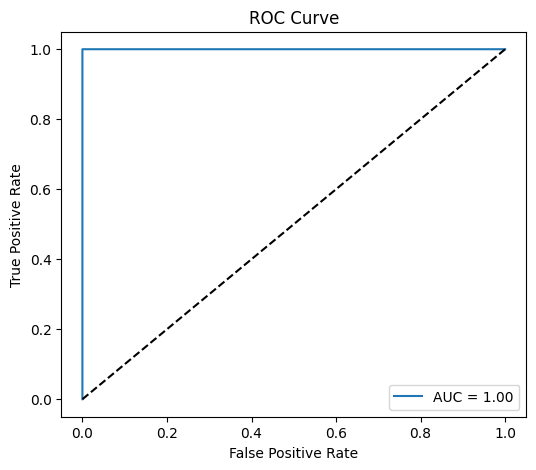

In [26]:
from sklearn.metrics import roc_curve, auc

# For binary classification only
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [28]:
import joblib

joblib.dump(best_model, "intrusion_detection_model.pkl")
print("✅ Model saved as intrusion_detection_model.pkl")


✅ Model saved as intrusion_detection_model.pkl


In [30]:
print(train_df.columns.tolist())

['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label']


In [33]:
# Select useful columns
selected_features = [
    "dur", "proto", "service", "state",
    "spkts", "dpkts", "sbytes", "dbytes",
    "sttl", "dttl", "sload", "dload",
    "tcprtt", "synack", "ackdat", "ct_state_ttl"
]

# Features and target
X = train_df[selected_features]
y = train_df["label"]

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in ["proto", "service", "state"]:
    X[col] = le.fit_transform(X[col])

# Split for training/testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE (optional but good for balance)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Train model
from sklearn.ensemble import RandomForestClassifier
rf_small = RandomForestClassifier(n_estimators=100, random_state=42)
rf_small.fit(X_train_res, y_train_res)

# Save model
import joblib
joblib.dump(rf_small, "rf_ids_modelv1.pkl")
print("✅ Model saved as rf_ids_model.pkl")


/tmp/ipython-input-1803900206.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipython-input-1803900206.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipython-input-1803900206.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

✅ Model saved as rf_ids_model.pkl


In [35]:
from google.colab import files
files.download("rf_ids_modelv1.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>